# Pump Affinity Laws

Pump affinity laws are similar to fan laws and were derived from similarity modeling considerations.

```{figure} fanlaws.png
---
width: 600px
name: fanlaws
---
Fan Laws Excerpt from CITE
```

A class of pumps that have geometrically similar shape and operation type (centrifugal, axial-flow, mixed-flow) are anticipated to behave according to the same correlations.  Such a set of pumps is called a homologous series.  For homologous pumps (say a collection of centrifugal pumps) the affinity relations are:

- Discharge scaling: $(\frac{Q}{nD^3})_1 = (\frac{Q}{nD^3})_2$
- Added head scaling: $(\frac{h_p}{n^2D^2})_1 = (\frac{h_p}{n^2D^2})_2$
- Power scaling: $(\frac{P}{n^3D^5})_1 = (\frac{P}{n^3D^5})_2$

Affinity laws are especially useful for estimating performance change with changes in speed ($n$ in the formulas), which is the easiest to control variable (using a variable frequency drive controller for example).  An illustrative example follows:

## Example: Pump Performance with Speed (RPM) Increase

The pump in the system depicted in numref`{example27-2}` has the characteristics given in numref`{example27-2-pmp}`.  Determine the discharge that will occur and the power required.

```{figure} example27-2.png
---
width: 600px
name: example27-2
---
Canal Lift Schematic
```

```{figure} example27-2-pmp.png
---
width: 600px
name: example27-2-pmp
---
Canal Pump Performance Curves
```

What will the discharge be if the pump speed is changed to 900 RPM?

### Step 1
State the problem; not much to add here - we will first find the operating point assuming the nominal pump speed on the performance curve, then use affinity laws to scale to the new speed.  As before we will approximate the curves using tabulations taken by visual examination of the supplied graphs.

### Step 2
Sketch the system; this too is also done for us - we stipulate that point 1 is the pool elevation in the lower canal, and point 2 is the centerline of the discharge pipe.

### Step 3
Known:
- water elevation
- discharge elevation
- pump curve
- pump speed (from the curve)
- pipe material, diameter, length
Unknown:
- Discharge $Q$
- Power $P$

### Step 4
Governing equations
- Modified bernoulli: $\frac{p_1}{\gamma}+z_1+\frac{V_1^2}{2g}+h_p(Q) = \frac{p_2}{\gamma}+z_2+\frac{V_2^2}{2g}+\frac{fL}{D}\frac{V^2}{2g}+K_{entrance}\frac{V^2}{2g}+K_{bend}\frac{V^2}{2g}+K_{exit}\frac{V^2}{2g}$
- Darcy-Weisbach pipeline loss model:  $h_{pipe loss} = \frac{fL}{D}\frac{V^2}{2g}$
- Continunity: $Q=VA$

### Step 5
Analysis/Solution Set-up<br>

Apply the modified Bernoulli equation from 1 to 2 <br>

$\frac{p_1}{\gamma}+z_1+\frac{V_1^2}{2g}+h_p(Q) = \frac{p_2}{\gamma}+z_2+\frac{V_2^2}{2g}+\frac{fL}{D}\frac{V^2}{2g}+K_{entrance}\frac{V^2}{2g}+K_{bend}\frac{V^2}{2g}+K_{exit}\frac{V^2}{2g}$

and observe that 

- $V_1 \approx~0$ at the free surface
- $p_1 = p_2 = 0 \text{ gage}$
- $K_{entrance} = 0.01$ table look-up or the mighty internet
- $K_{bend} = 0.35$ table look-up or the mighty internet
- $K_{exit} = 0.0$ no fitting here.

so our added head equation in this case becomes

$$h_p(V) = (z_2 - z_1) + \frac{V^2}{2g}[\frac{fL}{D}+K_{entrance}+K_{bend}]$$

Unlike the prior example, this time we will need to compute friction factors based on pipe material and discharge so we will need auxiliary functions to compute Reynolds' number and friction factors.  By far the easiest is to use the Jain approximation, repeated below from earlier lessons:

$Re_d(Q) = \frac{16 \rho D Q^2}{\mu \pi^2 D^4}$<br>

and<br>

$f=\frac{0.25}{[log_{10}(\frac{k_s}{3.7D}+\frac{5.74}{Re_d^{0.9}})]^2}$<br>

For this example we look up values for water for the Reynolds' number computations <br>

$\rho = 1000~\frac{kg}{m^3}$ and $\mu = 1.14\times10^{-3}~\frac{N s}{m^2}$

Now we write our prototype functions 

Using the same approach as before, except in SI units

In [12]:
def reynolds(flow,rho,mu,diameter):
    import math
    reynolds = rho*velocity(flow,diameter)*diameter/mu
    return(reynolds)

def jainff(roughness,diameter,reynolds):
    import math
    num = 0.25
    den= (math.log10(  (3.7*roughness/diameter)+(5.74/(reynolds**0.9)) ))**2
    jainff=num/den
    return(jainff)
    
def velocity(flow,diameter):
    import math
    velocity = (flow)/(0.25*math.pi*diameter**2)
    return(velocity)

def system_curve(z1,z2,flow,plength,pdiameter,pfriction_factor,k1,k2,k3,gravity):
    lift = (z2-z1)
    velocity_head = (velocity(flow,pdiameter)**2)/(2 * gravity)
    pipe_loss = (pfriction_factor*plength/pdiameter)*velocity_head
    fitting_loss = (k1+k2+k3)*velocity_head
    system_curve = lift+pipe_loss+fitting_loss
    return(system_curve)

length = 62.5 # overall length includes the bend and a little extra to clear the berm
zone = 20
ztwo = 21.5
rho = 1000
mu = 1.14e-03
diameter = 0.356
roughness = 0.0000265 # table lookup for steel in meters!
k1 = 0.01
k2 = 0.35
k3 = 0
gravity = 9.8
flowcms = [0 for i in range(1,16)] # list of flowrates
# convert to floating point
for i in range(len(flowcms)):
    flowcms[i]=0.00001+i*0.025 # sneaky way to get a list from 0 to 1 in steps of 0.1
addedheads = []
for i in range(len(flowcms)):
    red = reynolds(flowcms[i],rho,mu,diameter)
    ff = jainff(roughness,diameter,red)
    addedheads.append(system_curve(zone,ztwo,flowcms[i],length,diameter,ff,k1,k2,k3,gravity))
print("--- System Curve Table --- \n Flow (cms)  Added Head (m)")
for i in range(len(flowcms)):
    print(" ",round(flowcms[i],3),"        ",round(addedheads[i],3))

--- System Curve Table --- 
 Flow (cms)  Added Head (m)
  0.0          1.5
  0.025          1.514
  0.05          1.553
  0.075          1.618
  0.1          1.706
  0.125          1.82
  0.15          1.958
  0.175          2.121
  0.2          2.309
  0.225          2.521
  0.25          2.758
  0.275          3.019
  0.3          3.305
  0.325          3.616
  0.35          3.952


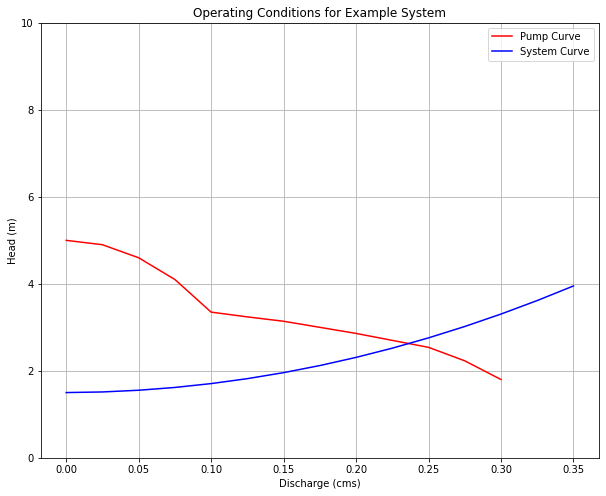

In [13]:
pumpflow = [0,0.025,0.05,0.075,0.10,0.125,0.15,0.20,0.25,0.275,0.30]
pumphead = [5,4.9,4.6,4.1,3.35,3.24,3.14,2.86,2.54,2.23,1.8]

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.plot(pumpflow,pumphead,c="red")
plt.plot(flowcms,addedheads, c="blue")
plt.legend(["Pump Curve","System Curve"])
plt.title("Operating Conditions for Example System")
plt.xlabel('Discharge (cms)') 
plt.ylim([0,10])
plt.ylabel('Head (m)') 
plt.grid(which='both')
plt.show()

In [14]:
myflow=0.24
myhead=round(system_curve(zone,ztwo,myflow,length,diameter,ff,k1,k2,k3,gravity),2)
print("Added head is ",myhead," meters for discharge of ",myflow*1000," liters per second")

Added head is  2.65  meters for discharge of  240.0  liters per second


So from the graphs, the operating point is at about $Q=0.24~\frac{m^3}{sec}$ with an operating head of $2.65~m$<br>

Next the power requirement is $P=\frac{Q\gamma h}{\eta}$  From the supplied curves, the efficiency at the design flowrate is about 80%.

In [15]:
power = 0.24*system_curve(zone,ztwo,0.24,length,diameter,ff,k1,k2,k3,gravity)*9800/0.8
print("Wire-to-water power in watts : ",round(power,3))

Wire-to-water power in watts :  7798.802


So the first part is done, now to adjust for a different pump speed.

The affinity laws in this case are:

**Discharge scaling:** <br>

$(\frac{Q}{nD^3})_1 = (\frac{Q}{nD^3})_2$ which after rearrangement for $Q_2$ the higher speed operation

$Q_2 = Q_1\frac{n_2}{n_1}\frac{D_2^3}{D_1^3}$

In [16]:
n1 = 690
n2 = 900
d1 = 1
d2 = 1
q1 = 0.24
q2 = q1*(n2/n1)*(d2**3/d1**3)
print("Scaled pump discharge ",round(q2,3))

Scaled pump discharge  0.313


Now determine the increased head loss

In [17]:
print("Increased RPM added head",round(system_curve(zone,ztwo,0.31,length,diameter,ff,k1,k2,k3,gravity),3))

Increased RPM added head 3.423


Now check that the pump will produce this much head using

**Added head scaling:**

$(\frac{h_p}{n^2D^2})_1 = (\frac{h_p}{n^2D^2})_2$



In [18]:
h1 = 2.65
h2 = h1*(n2**2/n1**2)*(d2**2/d1**2)
print("Scaled Pump Head ",round(h2,3))

Scaled Pump Head  4.509


So the pump appears to be able to produceeough head, now scale the power using 

**Power scaling:** 

$(\frac{P}{n^3D^5})_1 = (\frac{P}{n^3D^5})_2$

In [19]:
p1 = 7798*0.8 # we are working with mechanical power here
p2 = p1*(n2**3/n1**3)*(d2**5/d1**5)
print("Scaled Power ",round(p2,3))

Scaled Power  13843.741


### Step 6
A quick comment, the step to check that the scaled head is at least big enough to overcome the required added head at the new flow rate is often forgotten but should be checked.



## Readings

1. CE-3305-2022-1 Syllabus. [http://54.243.252.9/ce-3305-webroot/0-Syllabus/ce-3305-2022-1-syllabus.html](http://54.243.252.9/ce-3305-webroot/0-Syllabus/ce-3305-2022-1-syllabus.html)

2. Hibbeler, R.C, Fluid Mechanics, 2ed. Prentice Hall, 2018. ISBN: 9780134655413 pp. 569-596

3. DF Elger, BC Williams, Crowe, CT and JA Roberson, *Engineering Fluid Mechanics 10th edition*, John Wiley & Sons, Inc., 2013. [http://54.243.252.9/ce-3305-webroot/3-Readings/EFM-20.pdf](http://54.243.252.9/ce-3305-webroot/3-Readings/EFM-20.pdf)

4. Cleveland, T. G. (2014) *Fluid Mechanics Notes to Accompany CE 3305 at Jade-Holshule (TTU Study Abroad 2015-2019)*, Department of Civil, Environmental, and Construction Engineering, Whitacre College of Engineering. [missing_link](http://54.243.252.9/ce-3305-webroot/3-Readings/ce3305-lecture13.pdf)

 